<h3><center>Dogs vs Cats</center></h3>

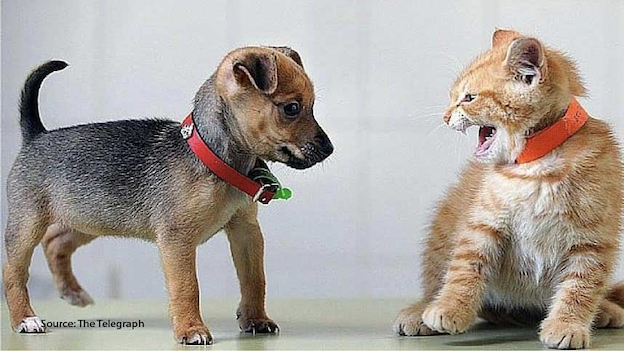

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd

from shutil import copyfile
from random import seed
from random import random

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.layers import Dropout

from keras.optimizers import SGD


<h3><center>1. Explore Dataset</center></h3>

In [ ]:
import zipfile

with zipfile.ZipFile('../input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

with zipfile.ZipFile('../input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
os.listdir('./train')[:10]

In [ ]:
folder = './train/'

plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(330 + 1 + i)
    
    filename = folder + 'dog.' + str(i) + '.jpg' 
    image = plt.imread(filename)
    
    plt.imshow(image)
    # show the figure
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(330 + 1 + i)
    
    filename = folder + 'cat.' + str(i) + '.jpg' 
    image = plt.imread(filename)
    
    plt.imshow(image)
    # show the figure
plt.show()

<h3><center>2. Preprocess photos into Directories to save RAM</center></h3>

<div style="font-family:verdana; word-spacing:1.7px;">
We can load the images progressively using the Keras ImageDataGenerator class and flow from directory() API. This will be slower to execute but will require less RAM. This API prefers data to be divided into separate train/ and test/ directories, and under each directory to have a subdirectory for each class, e.g. a train/dog/ and a train/cat/.
<br><br>
We will randomly select 25% of the images (or 6,250) to be used in a test dataset.
    </div>
    
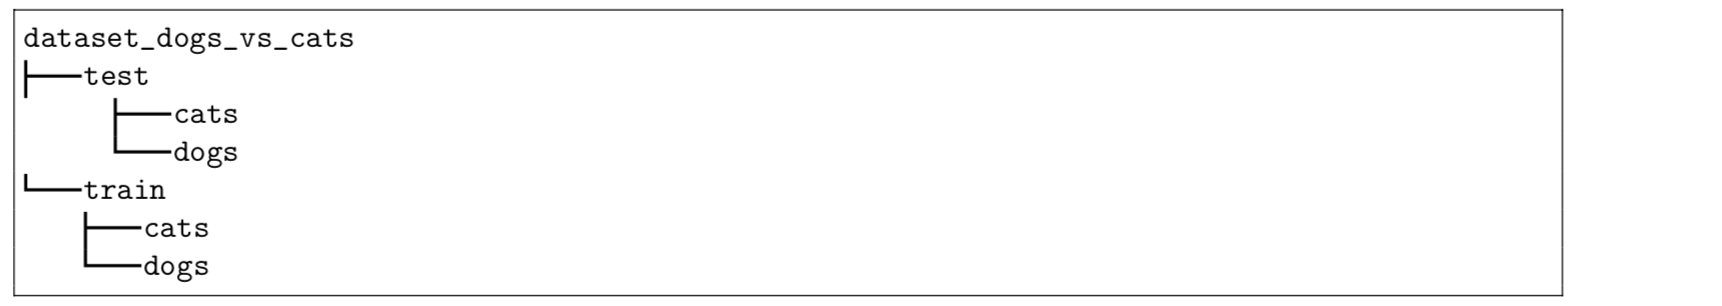

<h3>Make Directories</h3>

In [ ]:
HOME = './'
subdirs = ['training/', 'testing/']

for subdir in subdirs:
    labeldirs = ['dogs/', 'cats/']
    for labeldir in labeldirs:
        newdir = HOME + subdir + labeldir
        os.makedirs(newdir, exist_ok = True)

<h3>Load Images</h3>

In [ ]:
SRC_PATH = './train/'

seed(1)
val_ratio = 0.25

for file in tqdm(os.listdir(SRC_PATH)):
    src = SRC_PATH + file
    
    dest_dir = './training/'
    if random() < val_ratio:
        dest_dir = './testing/'
    
    if file.startswith('cat'):
        dest = dest_dir + 'cats/' + file
        copyfile(src, dest)
    else:
        dest = dest_dir + 'dogs/' + file
        copyfile(src, dest)      
    

<h3><center>3. Image DataGenerator</center></h3>
<div style="font-family:verdana; word-spacing:1.9px;">
Next, we need to prepare the data. This involves first defining an instance of the
ImageDataGenerator that will scale the pixel values to the range of 0-1
<br><br>
Next, iterators need to be prepared for both the train and test datasets. We can use the flow_from_directory() function on the data generator and create one iterator for each of the train/ and test/ directories.
<br><br>
We must specify that the problem is a binary classification problem via the class mode argument, and to load the images with the size of 200 × 200 pixels via the target size argument. We will fix the batch size at 64.
</div>

In [ ]:
TRAIN_PATH = './training/'
TEST_PATH = './testing'

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', 
                                      batch_size=64, target_size=(200,200))
test_it = datagen.flow_from_directory(TEST_PATH, class_mode='binary', 
                                      batch_size=64, target_size=(200,200))

In [ ]:
def summarize_diagnostics(history):
    plt.figure(figsize=(10,5))
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train') 
    plt.plot(history.history['val_loss'], color='orange', label='test')

        # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy') 
    plt.plot(history.history['accuracy'], color='blue', label='train') 
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.show()

<h3><center>4. Modelling</center></h3>

<h3><center>4.1. Baseline One block VGG Model</center></h3>

In [ ]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                    padding='same', input_shape=(200,200,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    
    opt=SGD(lr=0.01, momentum=0.9)
    
    model.compile(optimizer=opt, metrics=['accuracy'], loss='binary_crossentropy')
    return model

In [ ]:
model = define_model()

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              min_delta=1E-7)

history = model.fit_generator(train_it, steps_per_epoch=len(train_it), callbacks=[rlrop],
         epochs=10, validation_data=test_it, verbose=1)

In [ ]:
summarize_diagnostics(history)

Model couldn't learn and instead overfitting the training examples

In [ ]:
_, accuracy = model.evaluate_generator(test_it,  steps=len(test_it), verbose=1)
print(accuracy)

<h3><center>4.2. Baseline Three Block VGG Model</center></h3>

In [ ]:
def define_model():
    model = Sequential()
    #BLOCK 1
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                    padding='same', input_shape=(200,200,3)))
    model.add(MaxPooling2D((2,2)))
    
    #BLOCK 2
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform',
                    padding='same', input_shape=(200,200,3)))
    model.add(MaxPooling2D((2,2)))
    
    #BLOCK 3
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                    padding='same', input_shape=(200,200,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    
    opt=SGD(lr=0.01, momentum=0.9)
    
    model.compile(optimizer=opt, metrics=['accuracy'], loss='binary_crossentropy')
    return model

In [ ]:
model = define_model()

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              min_delta=1E-7)

history = model.fit_generator(train_it, steps_per_epoch=len(train_it), callbacks=[rlrop],
         epochs=10, validation_data=test_it, verbose=1)

In [ ]:
summarize_diagnostics(history)

In [ ]:
_, accuracy = model.evaluate_generator(test_it,  steps=len(test_it), verbose=1)
print(accuracy)

<h3><center>5. Develop Model Improvements</center></h3>
<h3><center>5.1. VGG3 + Dropout Regularization</center></h3>

In [ ]:
def define_model():
    model = Sequential()
    #BLOCK 1
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                    padding='same', input_shape=(200,200,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    
    #BLOCK 2
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform',
                    padding='same', input_shape=(200,200,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))
    
    #BLOCK 3
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                    padding='same', input_shape=(200,200,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    opt=SGD(lr=0.01, momentum=0.9)
    
    model.compile(optimizer=opt, metrics=['accuracy'], loss='binary_crossentropy')
    return model

In [ ]:
model = define_model()

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              min_delta=1E-7)

history = model.fit_generator(train_it, steps_per_epoch=len(train_it), 
                              callbacks=[rlrop], epochs=10, 
                              validation_data=test_it, validation_steps=len(test_it), 
                              verbose=1)

In [ ]:
summarize_diagnostics(history)

In [ ]:
_, accuracy = model.evaluate_generator(test_it,  steps=len(test_it), verbose=1)
print(accuracy)

<h3><center>5.2. VGG3 Baseline + Augmentation</center></h3>

In [ ]:
def define_model():
    model = Sequential()
    #BLOCK 1
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                    padding='same', input_shape=(200,200,3)))
    model.add(MaxPooling2D((2,2)))
    
    #BLOCK 2
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform',
                    padding='same', input_shape=(200,200,3)))
    model.add(MaxPooling2D((2,2)))
    
    #BLOCK 3
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                    padding='same', input_shape=(200,200,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    
    opt=SGD(lr=0.01, momentum=0.9)
    
    model.compile(optimizer=opt, metrics=['accuracy'], loss='binary_crossentropy')
    return model

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, 
                             height_shift_range=0.1, horizontal_flip=True)

# prepare iterators
train_it = datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', 
                                      batch_size=64, target_size=(200,200))
test_it = datagen.flow_from_directory(TEST_PATH, class_mode='binary', 
                                      batch_size=64, target_size=(200,200))

In [ ]:
model = define_model()

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              min_delta=1E-7)

history = model.fit_generator(train_it, steps_per_epoch=len(train_it), 
                              callbacks=[rlrop], epochs=10, 
                              validation_data=test_it, validation_steps=len(test_it), 
                              verbose=1)

In [ ]:
summarize_diagnostics(history)

In [ ]:
_, accuracy = model.evaluate_generator(test_it,  steps=len(test_it), verbose=1)
print(accuracy)

<h3><center>6. Transfer Learning using VGG-16</center></h3>

<div style="font-family:verdana; word-spacing:1.7px;">
VGG-16 with 16 layers achieved top results on the ImageNet photo classification challenge. The model is comprised of two main parts, the feature extractor part of the model that is made up of VGG blocks, and the classifier part of the model that is made up of fully connected layers and the output layer.<br><br>
We can use the feature extraction part of the model and add a new classifier part of the model that is tailored to the dogs and cats dataset.<br><br> Specifically, we can hold the weights of all of the convolutional layers fixed during training, and only train new fully connected layers that will learn to interpret the features extracted from the model and make a binary classification.<br><br> This can be achieved by loading the VGG-16 model, removing the fully connected layers from the output-end of the model, then adding the new fully connected layers to interpret the model output and make a prediction. The classifier part of the model can be removed automatically by setting the include top argument to False, which also requires that the shape of the input also be specified for the model, in this case (224, 224, 3). This means that the loaded model ends at the last max pooling layer, after which we can manually add a Flatten layer and the new classifier layers. 
    </div>

def define_model():
  model = VGG16(include_top=False, input_shape=(224, 224, 3))
  for layer in model.layers:
    layer.trainable = False
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation=✬relu✬, kernel_initializer=✬he_uniform✬)(flat1) output = Dense(1, activation=✬sigmoid✬)(class1)
model = Model(inputs=model.inputs, outputs=output)
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss=✬binary_crossentropy✬, metrics=[✬accuracy✬]) return model

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

def define_model():
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    
    for layer in model.layers:
        layer.trainable = False
    
    flat = Flatten()(model.layers[-1].output)
    dense1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat)
    output = Dense(1, activation='sigmoid')(dense1)
    
    model = Model(inputs=model.inputs, outputs=output)
    
    
    # Learning rate has been reduced to 0.001 as the model is already trained
    opt=SGD(lr=0.001, momentum=0.9)
    
    model.compile(optimizer=opt, metrics=['accuracy'], loss='binary_crossentropy')
    return model

<div style="font-family:verdana; word-spacing:1.7px;">
The model also expects images to be centered. That is, to have the mean pixel values from each channel (red, green, and blue) as calculated on the ImageNet training dataset subtracted from the input. Keras provides a function to perform this preparation for individual photos via the preprocess input() function. Nevertheless, we can achieve the same effect with the ImageDataGenerator by setting the featurewise center argument to True and manually specifying the mean pixel values to use when centering as the mean values from the ImageNet training dataset: [123.68, 116.779, 103.939]
    </div>

In [ ]:
datagen = ImageDataGenerator(featurewise_center=True)
datagen.mean = [123.68, 116.779, 103.939]

# prepare iterators
train_it = datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', 
                                      batch_size=64, target_size=(224,224))
test_it = datagen.flow_from_directory(TEST_PATH, class_mode='binary', 
                                      batch_size=64, target_size=(224,224))

In [ ]:
model = define_model()

history = model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=3, 
                              validation_data=test_it, validation_steps=len(test_it), 
                              verbose=1)

In [ ]:
summarize_diagnostics(history)

In [ ]:
_, accuracy = model.evaluate_generator(test_it,  steps=len(test_it), verbose=1)
print(accuracy)